In [86]:
# Database Dependencies
import pymongo
import gridfs
import pandas as pd
import io
import numpy as np
from PIL import Image, ImageOps
import subprocess
from config import DB_NAME, FEAT_3_COLLECTION_NAME, FEAT_30_COLLECTION_NAME
import json 

# Machine Learning Dependencies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting Dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Neural Network Dependencies
import tensorflow as tf
from tensorflow import keras

# Database Connection and Loading Data

In [118]:
# Establish mongo instance and get Music database
client = pymongo.MongoClient('localhost')
db = client[DB_NAME]

In [119]:
# Select 'feat_3' collection, and read in as pandas DataFrame
collection = db[FEAT_3_COLLECTION_NAME].find()
features_3_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_3_df = features_3_df.drop(columns = ["_id"])
features_3_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
1,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
2,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [120]:
# Select 'feat_30' collection, and read in as pandas DataFrame
collection = db[FEAT_30_COLLECTION_NAME].find()
features_30_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_30_df = features_30_df.drop(columns = ["_id"])
features_30_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [121]:
cwd_bytes = subprocess.check_output("pwd")
cwd = cwd_bytes.decode("utf-8").rstrip("\n") + "/"

In [122]:
# identify path for images
images_path = "Data/images_original/"

In [123]:
byte_images = subprocess.check_output(["ls", cwd + images_path])
images_folder = byte_images.decode("utf-8").split("\n")
images_folder.pop(-1)

''

In [124]:
# Establish the gridfs instance
fs = gridfs.GridFS(db)

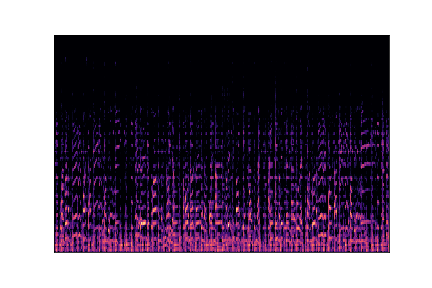

In [130]:
# Single Image Test
test_raw = fs.get_last_version("Data/images_original/blues/blues00000.png")
test_bytes = test_raw.read()
rgba_test = Image.open(io.BytesIO(test_bytes))
# RGBA Image (default)
rgba_test

In [131]:
# Converting RGBA TO RGB
rgb_test = rgba_test.convert("RGB")

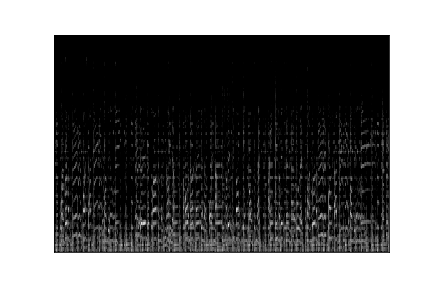

In [132]:
# Converting RGB to Grayscale
gray_test = ImageOps.grayscale(rgb_test)
gray_test

In [133]:
# Replicate single image loading/conversion to grayscale for all images
images = []
genres = []

for folder in images_folder:
    # Get files in each image-genre folder
    byte_files = subprocess.check_output(["ls", cwd + images_path + folder])
    files = byte_files.decode("utf-8").split("\n")
    files.pop(-1)
    
    for file in files:
        # Load image using its relative path as its GridFS identifier
        file_path = images_path + folder + "/" + file
        image_raw = fs.get_last_version(file_path)
        image_bytes = image_raw.read()
        rgba_image = Image.open(io.BytesIO(image_bytes))
        rgb_image = rgba_image.convert("RGB")
        gray_image = ImageOps.grayscale(rgb_image)
        image_data = np.asarray(gray_image)
        images.append(image_data)
        genres.append(folder)

In [134]:
# Convert image/genre lists to numpy arrays
images = np.asarray(images)
genres = np.asarray(genres)

# Supervised Machine Learning Models to Predict `label` from feature data

## `RandomForestClassifier`
### `features_3_sec.csv`

In [135]:
# Separate Features (X) from the Target (y)
y = features_3_df["label"]
X = features_3_df.drop(columns="label", axis=1)

In [136]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
1,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
2,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,8.479527e+05,...,5.773784,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969
9986,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,1.170890e+06,...,2.074155,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033
9987,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,2.602871e+06,...,-1.005473,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990
9988,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,4.968878e+05,...,4.123402,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750


In [137]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [138]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [139]:
# Instantiate the model
rf_3_model = RandomForestClassifier(n_estimators=1400, min_samples_split=2, min_samples_leaf=1,
                                    max_features="auto", max_depth=40, bootstrap=False)  # CHANGEABLE for bar plot comparisons

# Fit the model
rf_3_model = rf_3_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_3_pred = rf_3_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_3_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,8,8
1,8,8
2,9,9
3,0,0
4,6,9
...,...,...
2493,1,1
2494,3,3
2495,2,2
2496,0,0


In [140]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_3_pred)

Text(107.5, 0.5, 'True')

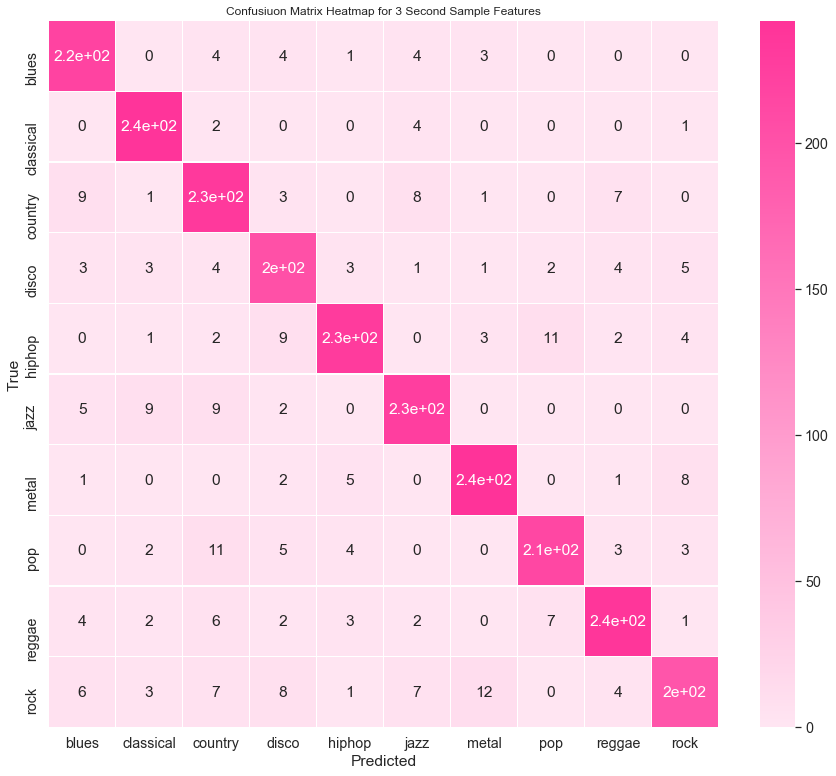

In [141]:
sortedlabels = genre_nums.keys()
cm_df = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)

sns.set(font_scale=1.3)
sns.heatmap(cm_df, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6), n_colors=10000), annot=True)
sns.set(rc={"figure.figsize": (15.0, 13.0)})

plt.title("Confusiuon Matrix Heatmap for 3 Second Sample Features")
plt.xlabel("Predicted")
plt.ylabel("True")

In [142]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_3_pred)
acc_score

0.8979183346677342

In [143]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_3_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       236
           1       0.92      0.97      0.94       247
           2       0.84      0.89      0.86       263
           3       0.85      0.89      0.87       229
           4       0.93      0.88      0.90       262
           5       0.90      0.90      0.90       251
           6       0.92      0.93      0.93       259
           7       0.91      0.88      0.90       242
           8       0.92      0.90      0.91       265
           9       0.90      0.80      0.85       244

    accuracy                           0.90      2498
   macro avg       0.90      0.90      0.90      2498
weighted avg       0.90      0.90      0.90      2498



In [144]:
classification_report_3_second = sklearn.metrics.classification_report(y_test, rf_3_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_3_second[str(i)]
total_accuracy = classification_report_3_second["accuracy"]
common_metrics = {"macro avg": classification_report_3_second["macro avg"],
                  "weighted avg": classification_report_3_second["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

In [145]:
print("Total Accuracy:", total_accuracy)

Total Accuracy: 0.8979183346677342


In [27]:
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/Genre_Metrics_3_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [28]:
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/common_metrics_3_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [147]:
# Most important features
# List in descending order by feature importance
importances = rf_3_model.feature_importances_
sorted(zip(importances, X), reverse=True)[:5]

[(0.05359973214099436, 'perceptr_var'),
 (0.03743487919867598, 'rms_var'),
 (0.035810335871761016, 'chroma_stft_mean'),
 (0.03361263388320814, 'rms_mean'),
 (0.03310244196316888, 'spectral_bandwidth_mean')]

### `features_30_sec.csv`

In [148]:
# Separate Features (X) from the Target (y)
y = features_30_df["label"]
X = features_30_df.drop(columns="label", axis=1)

In [149]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,1.222421e+06,...,1.789867,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665
996,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,1.046621e+06,...,3.739020,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624
997,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,8.042154e+05,...,1.838090,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515
998,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,1.332712e+06,...,-2.812176,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088


In [150]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [151]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [152]:
# Instantiate the model
rf_30_model = RandomForestClassifier(n_estimators=800, min_samples_split=5, min_samples_leaf=1,
                                     max_features="sqrt", max_depth=90, bootstrap=False) # CHANGEABLE for bar plot comparisons

# Fit the model
rf_30_model = rf_30_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_30_pred = rf_30_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_30_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,9,9
1,8,8
2,2,2
3,5,5
4,6,6
...,...,...
245,4,4
246,2,3
247,9,0
248,4,4


In [153]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_30_pred)

Text(107.5, 0.5, 'True')

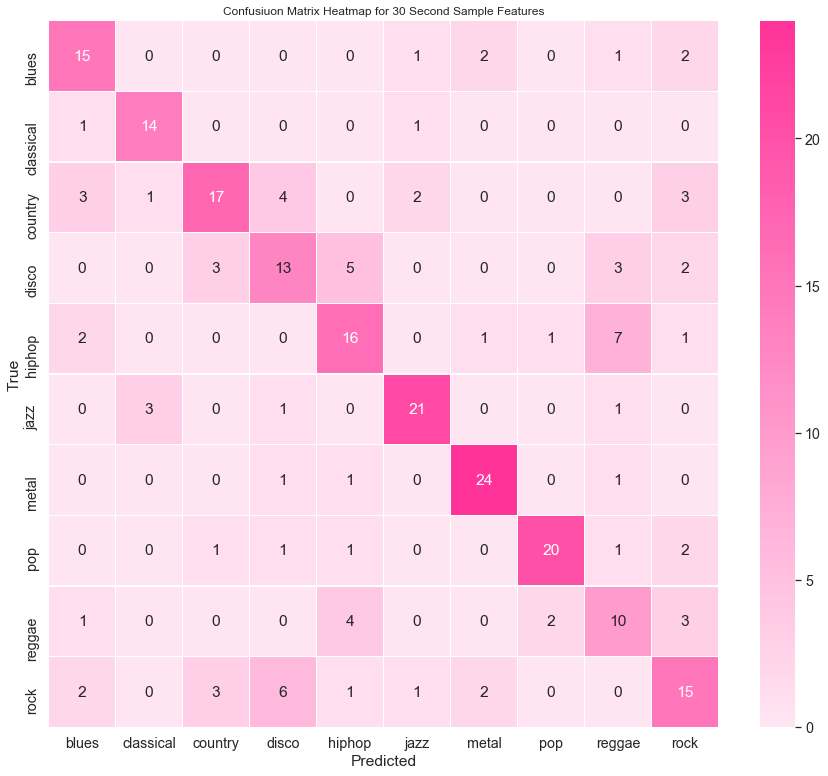

In [154]:
sortedlabels = genre_nums.keys()
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.3)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6), n_colors=10000), annot=True)
sns.set(rc={"figure.figsize": (15.0, 13.0)})

plt.title("Confusiuon Matrix Heatmap for 30 Second Sample Features")
plt.xlabel("Predicted")
plt.ylabel("True")

In [155]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_30_pred)
acc_score

0.66

In [156]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_30_pred))

              precision    recall  f1-score   support

           0       0.62      0.71      0.67        21
           1       0.78      0.88      0.82        16
           2       0.71      0.57      0.63        30
           3       0.50      0.50      0.50        26
           4       0.57      0.57      0.57        28
           5       0.81      0.81      0.81        26
           6       0.83      0.89      0.86        27
           7       0.87      0.77      0.82        26
           8       0.42      0.50      0.45        20
           9       0.54      0.50      0.52        30

    accuracy                           0.66       250
   macro avg       0.66      0.67      0.66       250
weighted avg       0.66      0.66      0.66       250



In [157]:
classification_report_30_second = sklearn.metrics.classification_report(y_test, rf_30_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_30_second[str(i)]
total_accuracy = classification_report_30_second["accuracy"]
common_metrics = {"macro avg": classification_report_30_second["macro avg"],
                  "weighted avg": classification_report_30_second["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

In [158]:
print("Total Accuracy:", total_accuracy)

Total Accuracy: 0.66


In [115]:
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/Genre_metrics_30_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [116]:
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/common_metrics_30_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [159]:
# Most important features
# List in descending order by feature importance
importances = rf_30_model.feature_importances_
sorted(zip(importances, X), reverse=True)[:5]

[(0.04893802846459198, 'perceptr_var'),
 (0.048055816202580245, 'chroma_stft_mean'),
 (0.036899034334662136, 'rms_mean'),
 (0.03537218579453566, 'rms_var'),
 (0.03318619371562234, 'chroma_stft_var')]

# Unsupervised Machine Learning Models to Predict `label` from feature data
## `KMeans` Cluster
### `features_3_sec.csv`

In [160]:
# Unsupervised Machine Learning Models to Predict `label` from feature data
# K-Means Cluster Model with 10 clusters (10 known genres)
# First shuffle the rows in DataFrame so the classes are not pre-grouped
# Needed here since not using sklearn.model_selection.train_test_split (no testing data)
features_3_df_shuffled = features_3_df.sample(frac=1)
features_3_df_shuffled

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
5277,jazz.00028.5.wav,66149,0.254437,0.085178,0.055219,0.000638,1789.253995,6.755638e+04,2054.131094,104037.657856,...,133.687439,-0.469856,75.578094,-5.252428,114.736298,-11.393669,143.509476,-6.280173,86.260559,jazz
3414,disco.00042.0.wav,66149,0.300403,0.084590,0.113502,0.001414,2405.081042,1.590760e+05,2368.400376,144025.996256,...,53.660793,6.329280,61.326389,11.944283,129.474396,4.952151,123.800720,0.872182,132.798965,disco
2596,country.00060.1.wav,66149,0.277306,0.083354,0.167074,0.000786,1427.222778,1.396557e+05,2116.763200,73748.130345,...,25.343935,-1.132493,39.467136,3.449078,96.457016,0.343605,42.553719,-6.415749,35.441204,country
60,blues.00006.0.wav,66149,0.263645,0.094391,0.184320,0.010181,1779.447516,5.740906e+05,1576.854804,217374.784879,...,118.168427,-11.323107,93.340942,-8.468267,35.701008,-6.997897,62.537056,-9.623995,81.041290,blues
5278,jazz.00028.6.wav,66149,0.267971,0.090172,0.059722,0.001382,1880.433027,1.806940e+05,2070.081916,131517.864832,...,170.471100,-1.277463,103.072830,-0.719341,105.477577,-5.695299,117.372643,-1.462559,216.222702,jazz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5270,jazz.00027.8.wav,66149,0.335933,0.091714,0.041313,0.000156,1813.864320,1.104396e+05,2139.934965,54832.090171,...,74.826393,-1.091555,121.819893,-1.113921,94.771362,-3.470114,49.020298,-2.496869,40.082340,jazz
7935,pop.00094.3.wav,66149,0.212743,0.077126,0.272426,0.002189,3004.994497,3.417676e+05,3268.321372,140090.137971,...,34.907700,0.402109,119.258942,2.204855,256.009430,8.753133,50.765755,2.740059,37.878983,pop
2572,country.00057.7.wav,66149,0.300870,0.081868,0.131714,0.001586,2116.932842,1.306152e+05,2433.088547,40215.943604,...,23.454388,-10.295110,24.807262,-1.642342,19.355473,-9.916178,18.339336,-1.564420,16.589924,country
271,blues.00027.1.wav,66149,0.345462,0.092590,0.079414,0.001414,1073.566091,2.710030e+04,1545.155433,25841.701513,...,18.315426,-8.729304,25.568293,-12.929424,18.614819,-1.944972,30.508816,-1.116045,62.277748,blues


In [161]:
# Separate Features (X) from the Target (y)
y = features_3_df_shuffled["label"]
X = features_3_df_shuffled.drop(columns="label", axis=1)

In [162]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
5277,0.254437,0.085178,0.055219,0.000638,1789.253995,6.755638e+04,2054.131094,104037.657856,3902.064866,8.385041e+05,...,10.997852,133.687439,-0.469856,75.578094,-5.252428,114.736298,-11.393669,143.509476,-6.280173,86.260559
3414,0.300403,0.084590,0.113502,0.001414,2405.081042,1.590760e+05,2368.400376,144025.996256,4836.026142,1.424573e+06,...,-3.982528,53.660793,6.329280,61.326389,11.944283,129.474396,4.952151,123.800720,0.872182,132.798965
2596,0.277306,0.083354,0.167074,0.000786,1427.222778,1.396557e+05,2116.763200,73748.130345,3464.112643,1.487093e+06,...,15.165225,25.343935,-1.132493,39.467136,3.449078,96.457016,0.343605,42.553719,-6.415749,35.441204
60,0.263645,0.094391,0.184320,0.010181,1779.447516,5.740906e+05,1576.854804,217374.784879,3481.007925,2.050361e+06,...,-7.729857,118.168427,-11.323107,93.340942,-8.468267,35.701008,-6.997897,62.537056,-9.623995,81.041290
5278,0.267971,0.090172,0.059722,0.001382,1880.433027,1.806940e+05,2070.081916,131517.864832,4009.399602,1.285832e+06,...,1.424397,170.471100,-1.277463,103.072830,-0.719341,105.477577,-5.695299,117.372643,-1.462559,216.222702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5270,0.335933,0.091714,0.041313,0.000156,1813.864320,1.104396e+05,2139.934965,54832.090171,4021.242864,6.321302e+05,...,10.260376,74.826393,-1.091555,121.819893,-1.113921,94.771362,-3.470114,49.020298,-2.496869,40.082340
7935,0.212743,0.077126,0.272426,0.002189,3004.994497,3.417676e+05,3268.321372,140090.137971,7565.856558,2.763553e+06,...,1.927644,34.907700,0.402109,119.258942,2.204855,256.009430,8.753133,50.765755,2.740059,37.878983
2572,0.300870,0.081868,0.131714,0.001586,2116.932842,1.306152e+05,2433.088547,40215.943604,5178.486892,5.592296e+05,...,1.266492,23.454388,-10.295110,24.807262,-1.642342,19.355473,-9.916178,18.339336,-1.564420,16.589924
271,0.345462,0.092590,0.079414,0.001414,1073.566091,2.710030e+04,1545.155433,25841.701513,2483.192420,4.130433e+05,...,2.673645,18.315426,-8.729304,25.568293,-12.929424,18.614819,-1.944972,30.508816,-1.116045,62.277748


In [163]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'jazz': 0,
 'disco': 1,
 'country': 2,
 'blues': 3,
 'metal': 4,
 'pop': 5,
 'classical': 6,
 'hiphop': 7,
 'rock': 8,
 'reggae': 9}

In [164]:
# Standardize features with StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Initialize PCA model with 3 principal components to visualize clusters vs. components
pca = PCA(n_components=3)

# Fit pca model to the 30 sec music feature data, X
X_pca = pca.fit_transform(X_scaled)

# Transform PCA data to a DataFrame
df_pca = pd.DataFrame(
    data=X_pca, columns=["principal component 1", "principal component 2", "principal component 3"]
)
df_pca.head()

,principal component 1,principal component 2,principal component 3
0,-2.615329,2.650075,2.098646
1,0.631708,1.056449,-1.038028
2,-2.069961,0.558461,1.553424
3,7.535441,3.295480,4.274868
4,0.112157,4.034743,4.168370


In [165]:
# Fetch the explained variance
pca.explained_variance_ratio_  # 1st component contains 20% of variance, 2nd contains 14%, 3rd contains 10%

array([0.20054986, 0.13542712, 0.1034532 ])

In [166]:
# Initialize the K-means model
km_3_model = KMeans(n_clusters=10, random_state=0)

# Fit the model
km_3_model.fit(df_pca)

# Predict clusters
predictions = km_3_model.predict(df_pca)

# Add the preicted class columns
df_pca["predicted class"] = km_3_model.labels_
df_pca["actual class"] = np.asarray(y)
df_pca

,principal component 1,principal component 2,principal component 3,predicted class,actual class
0,-2.615329,2.650075,2.098646,3,0
1,0.631708,1.056449,-1.038028,6,1
2,-2.069961,0.558461,1.553424,3,2
3,7.535441,3.295480,4.274868,7,3
4,0.112157,4.034743,4.168370,1,0
...,...,...,...,...,...
9985,-3.648843,1.096044,0.728711,3,0
9986,3.201500,-1.125859,-1.728418,2,5
9987,-4.314286,-0.823646,-0.158825,8,2
9988,-2.574664,3.079993,-2.275230,4,3


In [167]:
# Plotting clusters with three features
fig = px.scatter_3d(df_pca, x="principal component 1", y="principal component 2", z="principal component 3",
                    color="predicted class", symbol="predicted class", width=800, title="Predicted Genre Clusters",
                    hover_data=["actual class"])
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [168]:
# Labels not insightful, no reason for program to label all "blues" as 0
# Check number of each prediction:
df_pca["predicted class"].value_counts(sort=False)

0    1095
8    1884
1     895
9     463
2     960
3     939
4    1057
5    1077
6    1096
7     524
Name: predicted class, dtype: int64

In [169]:
# Compare to actual class breakdown
df_pca["actual class"].value_counts(sort=False)

0    1000
8     998
1     999
9    1000
2     997
3    1000
4    1000
5    1000
6     998
7     998
Name: actual class, dtype: int64

In [170]:
# Check number of actual class labels for a single predicted label
# Ideally we would find many of one actual class label and few of others for each predicted label, and a unique most 
# popular actual label for each predicted label
act_pred_results = np.zeros((10, 10), dtype=int)
col_names = []
for i in range(10):
    for j in range(10):
        try:
            act_pred_results[i, j] = df_pca[df_pca["predicted class"] == i]["actual class"].value_counts(sort=False)[j]
        except KeyError:
            act_pred_results[i, j] = 0
    col_names.append("Number of Actual %s" % i)

act_pred_results_df = pd.DataFrame(data=act_pred_results,
                                   columns=col_names)

In [171]:
act_pred_results_df.columns = list(genre_nums.keys())
act_pred_results_df.index = list(genre_nums.keys())
act_pred_results_df.index.rename("Predicted Class", inplace=True)
act_pred_results_df = act_pred_results_df[["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"]]
act_pred_results_df = act_pred_results_df.reindex(["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"])
act_pred_results_df

,jazz,metal,disco,pop,reggae,classical,rock,blues,hiphop,country
Predicted Class,,,,,,,,,,
jazz,119,24,269,238,53,9,183,0,93,107
metal,242,2,1,6,8,563,32,96,5,102
disco,186,0,10,10,52,214,14,254,10,145
pop,7,55,238,0,131,9,123,169,221,124
reggae,1,1,1,220,73,0,2,0,163,2
classical,144,3,119,110,230,14,127,21,74,254
rock,13,857,229,0,27,0,306,252,130,70
blues,249,43,39,0,24,146,164,119,5,150
hiphop,32,13,16,37,194,43,20,89,52,28


In [115]:
result = act_pred_results_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/act_pred_3_sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

### `features_30_sec.csv`

In [172]:
# Unsupervised Machine Learning Models to Predict `label` from feature data
# K-Means Cluster Model with 10 clusters (10 known genres)
# First shuffle the rows in DataFrame so the classes are not pre-grouped
# Needed here since not using sklearn.model_selection.train_test_split (no testing data)
features_30_df_shuffled = features_30_df.sample(frac=1)
features_30_df_shuffled

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
601,metal.00001.wav,661504,0.476903,0.071958,0.097298,0.000218,2922.845195,1.838965e+05,2620.939220,49910.397474,...,37.298557,-9.028761,37.896343,5.506845,34.330849,-6.194880,43.079819,3.124241,40.535103,metal
579,jazz.00079.wav,661794,0.338348,0.084579,0.069850,0.000386,2634.043030,3.609089e+05,2728.240133,118663.560223,...,95.797638,-1.760361,98.465599,-5.186886,61.105072,-5.654775,68.589348,-9.772271,93.788239,jazz
236,country.00036.wav,661794,0.344722,0.086342,0.022782,0.000259,1827.591866,5.740861e+05,2050.071064,136295.000439,...,64.574135,-10.716799,56.087189,-7.720544,60.793751,-3.425799,70.676575,-6.953691,109.831161,country
380,disco.00080.wav,661504,0.388546,0.091958,0.059242,0.001042,2144.366952,5.634082e+05,2414.494154,104186.488084,...,51.194580,-9.557693,72.283188,-0.748921,57.475891,-4.540810,61.608536,-3.683267,46.809685,disco
15,blues.00015.wav,661794,0.269690,0.094989,0.080624,0.002829,1420.365165,1.999590e+05,1731.164281,81354.261510,...,77.410767,-6.887469,93.530945,-4.823252,65.716705,1.747367,78.390366,-1.882196,131.138275,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,country.00035.wav,661794,0.375874,0.081557,0.099977,0.001147,2321.871533,5.433791e+05,2545.325000,155899.829366,...,51.811581,-3.584000,51.066288,-5.018315,47.032211,-2.522085,35.879490,-4.752133,33.392231,country
475,hiphop.00075.wav,661794,0.451151,0.096722,0.191646,0.014995,3140.810674,1.781900e+06,2849.980909,136864.067076,...,55.174568,-4.118448,53.688320,-1.104125,47.380569,-0.124494,46.204937,-2.755772,45.098331,hiphop
782,pop.00082.wav,661504,0.462013,0.090105,0.207990,0.007258,3168.891347,6.261901e+05,3341.561494,83194.537030,...,40.104065,1.293545,39.982609,1.177401,44.843281,0.854013,57.629005,0.104496,65.040146,pop
241,country.00041.wav,661794,0.397855,0.082284,0.113301,0.000587,2634.080774,8.207470e+05,2898.541576,233608.971679,...,42.996780,-2.325614,41.673706,-4.613111,41.339603,-0.618727,29.171967,-4.939899,29.804676,country


In [173]:
# Separate Features (X) from the Target (y)
y = features_30_df_shuffled["label"]
X = features_30_df_shuffled.drop(columns="label", axis=1)

In [174]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
601,0.476903,0.071958,0.097298,0.000218,2922.845195,1.838965e+05,2620.939220,49910.397474,6037.074142,6.772574e+05,...,5.930048,37.298557,-9.028761,37.896343,5.506845,34.330849,-6.194880,43.079819,3.124241,40.535103
579,0.338348,0.084579,0.069850,0.000386,2634.043030,3.609089e+05,2728.240133,118663.560223,5561.653325,1.657088e+06,...,-1.081032,95.797638,-1.760361,98.465599,-5.186886,61.105072,-5.654775,68.589348,-9.772271,93.788239
236,0.344722,0.086342,0.022782,0.000259,1827.591866,5.740861e+05,2050.071064,136295.000439,3647.221668,2.281949e+06,...,-8.312078,64.574135,-10.716799,56.087189,-7.720544,60.793751,-3.425799,70.676575,-6.953691,109.831161
380,0.388546,0.091958,0.059242,0.001042,2144.366952,5.634082e+05,2414.494154,104186.488084,4958.240681,2.363090e+06,...,0.244298,51.194580,-9.557693,72.283188,-0.748921,57.475891,-4.540810,61.608536,-3.683267,46.809685
15,0.269690,0.094989,0.080624,0.002829,1420.365165,1.999590e+05,1731.164281,81354.261510,2929.964495,7.000990e+05,...,-5.540558,77.410767,-6.887469,93.530945,-4.823252,65.716705,1.747367,78.390366,-1.882196,131.138275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.375874,0.081557,0.099977,0.001147,2321.871533,5.433791e+05,2545.325000,155899.829366,4580.418732,2.651598e+06,...,-0.442143,51.811581,-3.584000,51.066288,-5.018315,47.032211,-2.522085,35.879490,-4.752133,33.392231
475,0.451151,0.096722,0.191646,0.014995,3140.810674,1.781900e+06,2849.980909,136864.067076,6336.698754,3.352306e+06,...,-0.436722,55.174568,-4.118448,53.688320,-1.104125,47.380569,-0.124494,46.204937,-2.755772,45.098331
782,0.462013,0.090105,0.207990,0.007258,3168.891347,6.261901e+05,3341.561494,83194.537030,7555.806129,1.689806e+06,...,0.809471,40.104065,1.293545,39.982609,1.177401,44.843281,0.854013,57.629005,0.104496,65.040146
241,0.397855,0.082284,0.113301,0.000587,2634.080774,8.207470e+05,2898.541576,233608.971679,5807.827964,4.557787e+06,...,0.558818,42.996780,-2.325614,41.673706,-4.613111,41.339603,-0.618727,29.171967,-4.939899,29.804676


In [175]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'metal': 0,
 'jazz': 1,
 'country': 2,
 'disco': 3,
 'blues': 4,
 'hiphop': 5,
 'pop': 6,
 'classical': 7,
 'rock': 8,
 'reggae': 9}

In [176]:
# Standardize features with StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Initialize PCA model with 3 principal components to visualize clusters vs. components
pca = PCA(n_components=3)

# Fit pca model to the 30 sec music feature data, X
X_pca = pca.fit_transform(X_scaled)

# Transform PCA data to a DataFrame
df_pca = pd.DataFrame(
    data=X_pca, columns=["principal component 1", "principal component 2", "principal component 3"]
)
df_pca.head()

,principal component 1,principal component 2,principal component 3
0,-5.101038,1.701652,0.278560
1,0.926783,-0.469705,-2.919085
2,2.420250,-1.854062,-1.503268
3,-1.052602,-1.038308,1.815305
4,2.531014,-2.844609,-0.501129


In [177]:
# Fetch the explained variance
pca.explained_variance_ratio_  # 1st component contains 24% of variance, 2nd contains 17%, 3rd contains 11%

array([0.23949564, 0.16929248, 0.10750028])

In [178]:
# Initialize the K-means model
km_30_model = KMeans(n_clusters=10, random_state=0)

# Fit the model
km_30_model.fit(df_pca)

# Predict clusters
predictions = km_30_model.predict(df_pca)

# Add the preicted class columns
df_pca["predicted class"] = km_30_model.labels_
df_pca["actual class"] = np.asarray(y)
df_pca

,principal component 1,principal component 2,principal component 3,predicted class,actual class
0,-5.101038,1.701652,0.278560,3,0
1,0.926783,-0.469705,-2.919085,2,1
2,2.420250,-1.854062,-1.503268,2,2
3,-1.052602,-1.038308,1.815305,0,3
4,2.531014,-2.844609,-0.501129,6,4
...,...,...,...,...,...
995,1.385885,0.553776,-2.258824,2,2
996,7.111489,6.302621,2.652508,1,5
997,0.084245,4.450736,-3.197779,5,6
998,1.224863,2.400753,-3.559928,5,2


In [179]:
# Plotting clusters with three features
fig = px.scatter_3d(df_pca, x="principal component 1", y="principal component 2", z="principal component 3",
                    color="predicted class", symbol="predicted class", width=800, title="Predicted Genre Clusters",
                    hover_data=["actual class"])
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [180]:
# Labels not insightful, no reason for program to label all "blues" as 0
# Check number of each prediction:
df_pca["predicted class"].value_counts(sort=False)

0    150
1     76
2    101
3    182
4     12
5    117
6    114
7     84
8     59
9    105
Name: predicted class, dtype: int64

In [181]:
# Compare to actual class breakdown
df_pca["actual class"].value_counts(sort=False)

0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: actual class, dtype: int64

In [182]:
# Check number of actual class labels for a single predicted label
# Ideally we would find many of one actual class label and few of others for each predicted label, and a unique most 
# popular actual label for each predicted label
act_pred_results = np.zeros((10, 10), dtype=int)
col_names = []
for i in range(10):
    for j in range(10):
        try:
            act_pred_results[i, j] = df_pca[df_pca["predicted class"] == i]["actual class"].value_counts(sort=False)[j]
        except KeyError:
            act_pred_results[i, j] = 0
    col_names.append("Number of Actual %s" % i)

act_pred_results_df = pd.DataFrame(data=act_pred_results,
                                   columns=col_names)

In [183]:
act_pred_results_df.columns = list(genre_nums.keys())
act_pred_results_df.index = list(genre_nums.keys())
act_pred_results_df.index.rename("Predicted Class", inplace=True)
act_pred_results_df = act_pred_results_df[["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"]]
act_pred_results_df = act_pred_results_df.reindex(["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"])
act_pred_results_df

,jazz,metal,disco,pop,reggae,classical,rock,blues,hiphop,country
Predicted Class,,,,,,,,,,
jazz,1,0,0,35,18,0,2,0,19,1
metal,10,11,28,0,6,3,26,24,19,23
disco,4,85,20,0,2,0,32,24,9,6
pop,21,0,1,2,2,40,0,32,0,16
reggae,36,0,0,0,2,47,4,7,0,9
classical,1,0,9,38,8,0,1,0,27,0
rock,0,1,5,0,26,1,4,3,16,3
blues,3,0,0,4,1,4,0,0,0,0
hiphop,16,3,30,10,8,1,23,0,7,19


In [85]:
result = act_pred_results_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/act_pred_30_sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

# Neural Network to Predict `label` from Images

In [66]:
# Copy images and labels into new NumPy arrays
X = np.copy(images)
y = np.copy(genres)

In [67]:
# Convert categorical labels to integers 0 - 9
y = np.vectorize(genre_nums.get)(y)

In [68]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [69]:
# Normalize pixel data:
X_train = X_train / 255
X_test = X_test / 255

In [70]:
# Define Neural Net
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[288, 432]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")])

In [71]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 124416)            0         
_________________________________________________________________
dense (Dense)                (None, 300)               37325100  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 37,376,410
Trainable params: 37,376,410
Non-trainable params: 0
____________________________________________

In [72]:
# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [73]:
# Train the model
history = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
24/24 [==============================] - 3s 109ms/step - loss: 3.2197 - accuracy: 0.0804
Epoch 2/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3443 - accuracy: 0.0953
Epoch 3/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3257 - accuracy: 0.0982
Epoch 4/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3209 - accuracy: 0.0891
Epoch 5/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3134 - accuracy: 0.0786
Epoch 6/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3143 - accuracy: 0.0900
Epoch 7/200
24/24 [==============================] - 3s 110ms/step - loss: 2.2971 - accuracy: 0.1340
Epoch 8/200
24/24 [==============================] - 3s 109ms/step - loss: 2.2947 - accuracy: 0.1255
Epoch 9/200
24/24 [==============================] - 3s 108ms/step - loss: 2.2841 - accuracy: 0.1511
Epoch 10/200
24/24 [==============================] - 3s 110ms/step - loss: 2.2835 - accura

24/24 [==============================] - 3s 110ms/step - loss: 1.5474 - accuracy: 0.4345
Epoch 161/200
24/24 [==============================] - 3s 111ms/step - loss: 1.6131 - accuracy: 0.4408
Epoch 162/200
24/24 [==============================] - 3s 108ms/step - loss: 1.5167 - accuracy: 0.4461
Epoch 163/200
24/24 [==============================] - 3s 108ms/step - loss: 1.5401 - accuracy: 0.4395
Epoch 164/200
24/24 [==============================] - 3s 109ms/step - loss: 1.6168 - accuracy: 0.3792
Epoch 165/200
24/24 [==============================] - 3s 109ms/step - loss: 1.6759 - accuracy: 0.3576
Epoch 166/200
24/24 [==============================] - 3s 109ms/step - loss: 1.7231 - accuracy: 0.3638
Epoch 167/200
24/24 [==============================] - 3s 110ms/step - loss: 1.5499 - accuracy: 0.4039
Epoch 168/200
24/24 [==============================] - 3s 108ms/step - loss: 1.6492 - accuracy: 0.4112
Epoch 169/200
24/24 [==============================] - 3s 109ms/step - loss: 1.6354 - a

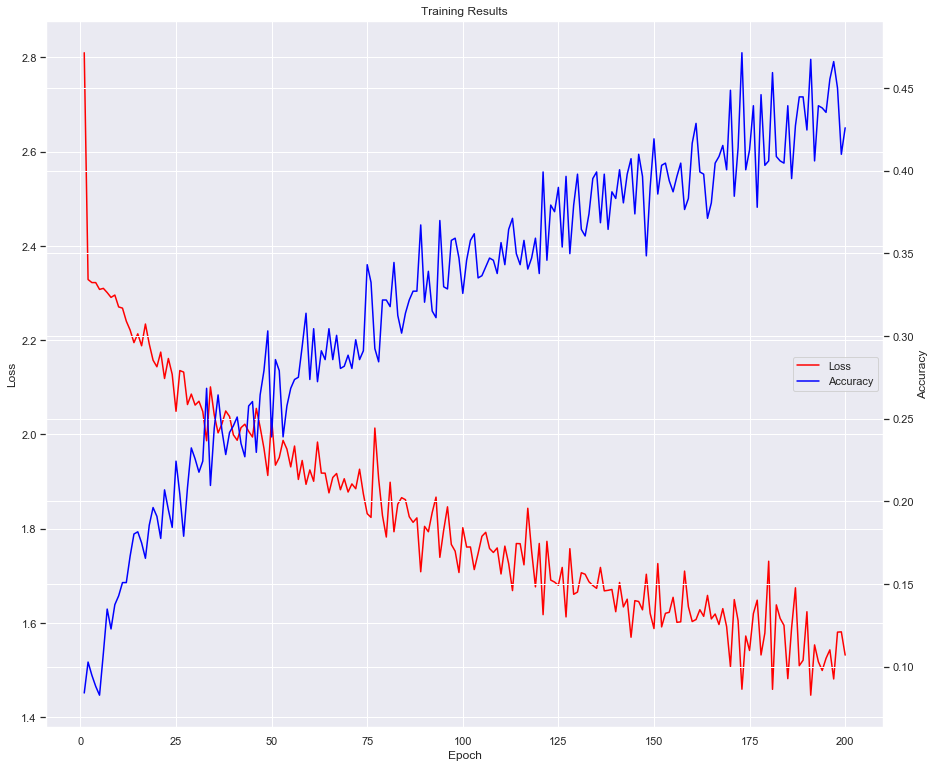

In [74]:
# Plot training results
history_df = pd.DataFrame(history.history,
                          index=range(1, len(history.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="red", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Results")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="blue", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [75]:
# Evaluate model
model.evaluate(X_test, y_test)  # Likely overfitting: 0.6 training accuracy -> 0.34 testing accuracy

8/8 [==============================] - 0s 25ms/step - loss: 2.3845 - accuracy: 0.2400


[2.3844616413116455, 0.23999999463558197]

In [88]:
nn_pred_probs = model.predict(X_test)
nn_pred = np.argmax(nn_pred_probs, axis=1)
results = pd.DataFrame({
    "Prediction": nn_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,1,0
1,4,7
2,7,6
3,5,5
4,7,9
...,...,...
245,1,6
246,7,7
247,2,8
248,7,7


In [85]:
classification_report_nn = sklearn.metrics.classification_report(y_test, nn_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_nn[str(i)]
total_accuracy = classification_report_nn["accuracy"]
common_metrics = {"macro avg": classification_report_nn["macro avg"],
                  "weighted avg": classification_report_nn["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [90]:
print("Total Accuracy:", total_accuracy)

Total Accuracy: 0.24


In [91]:
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/Genre_metrics_nn.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [92]:
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/common_metrics_30_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()